---
description: Here we show how to solve the Deep Space Network scheduling problem introduced by [Guillaume et al. (2022)] using JijZept.
---

# Deep Space Network Scheduling 

<!-- # 電波望遠鏡ネットワークのスケジュール最適化 -->

<!-- ## 導入: Deep Space Network (DSN) -->

## Introduction: Deep Space Network (DSN)

<!-- NASAのDeep Space Network（以下DSNと呼称します）は、オーストラリア・スペイン・アメリカにまたがる電波望遠鏡を繋いだネットワークです。
これらの電波望遠鏡は主に、宇宙に打ち上げられた宇宙探査機との交信、そして電波波長帯域での惑星観測ミッションに役立てられています。
探査機数そして交信の複雑さが増す昨今では、どのアンテナをどの探査機との交信に用いるか（あるいはどのミッションに割り当てるか）のスケジュール決定は困難を極めます。
近年では複数台の電波望遠鏡をネットワークで繋ぎ、これをあるパターンに従って操作することで信号間の干渉を利用した、電波干渉計技術が注目を集めています。
Event Horizon Telescopeが行ったM87、そして私たちの住む天の川銀河中心の超巨大ブラックホールの直接撮像などが、その際たる例です。  
[Guillaume et al., 2022](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9863923)では、DNSのスケジューリング問題をQUBO定式化し、D-Waveのハイブリッドソルバーを用いて解きました。
今回はその定式化を理解した上でJijModelingで実装し、JijZeptで求解してみましょう。 -->

NASA's Deep Space Network (hereafter referred to as DSN) is a network of radio telescopes. 
These sites are Australia, Spain, and the United States.
These radio telescopes are used primarily for communication with spacecraft launched into space and for planetary observation missions in the radio wavelength band.
With the increasing number and complexity of spacecraft, communication scheduling with spacecraft is an extremely difficult problem.
In recent years, radio interferometry, a technique that uses interference between signals by networking multiple radio telescopes and manipulating them according to a pattern, has attracted much attention.
The most notable example is [Event Horizon Telescope](https://eventhorizontelescope.org/) which took the direct imaging of the supermassive black hole at the center of M87 and Milky Way Galaxy.  
[Guillaume et al. (2022)](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9863923) formulated the DNS scheduling problem into QUBO and solved using D-Wave's hybrid solver.
Here, we implement this problem using JijModeling and solve it with JijZept.

<!-- ## DSNのスケジュール問題 -->

## DSN scheduling problem

<!-- ### 問題設定-->

### Problem setting

<!-- $N$個のリクエストがあり、これを$\mathcal{Q} = \{Q_1, Q_2, \dots, Q_N\}$とします。
あるリクエスト$Q_n$が$M$個の(アンテナや装置などの地上の)リソースに割り当てられることを考えます。
このリソースの集合を$\mathcal{S} = \{S_1, S_2, \dots, S_M\}$のように書きます。
各地上のリソース$S_m$に対し、宇宙にある衛星が見える期間を$\mathcal{V} = \{V_1, V_2, \dots, V_K\}$とします。
衛星が見える期間の開始(rise time)と終了(set time)をそれぞれrt, stのように定義します。
実際に衛星に信号を送信が開始できるようになるのは、rtからわずかに遅れた時間となります。また送信ができるのはstから少し早い時間までです。
このように、実際に送信が開始できる時間と送信が終了する時間をtn, tfのように書きます。
各リクエストに対して、要求された装置を準備し、またそれを撤去するための時間がかかります。
それらをsu, tdとします。
これらはrt, stの間ならば、いつでも発生します。
さらに各リクエストには、トラッキングの継続時間drが定められます。
これらの定義から、各リクエストはsu+dr+tdだけアクションに時間を取ります。
この時間の間、アンテナや装置は衛星をトラッキングし、衛星と通信を行うことができます。  
これらをインスタンスとして、最適化を行います。
DSNスケジュール最適化の目的は、全てのリクエストを満たすこと、言い換えればリクエストごとに正確に一つのアクションをスケジュールすることです。
そのために、$x_{n, m, k, t}$のようなバイナリ変数を用意しましょう。
これは時刻$t$からトラッキングを開始し、衛星が見える期間$k$の間にリソース$m$を用いてリクエスト$n$を処理する場合に1、そうでない場合に0となるようなバイナリ変数です。 -->

A schedule is generated after processing $N$ requests $\mathcal{Q} = \{Q_1, Q_2, \dots, Q_N\}$.
A given request $Q_n$ can utilize any of the $M$ resources (antennas or equipments) prescribed for this request $\mathcal{S} = \{S_1, S_2, \dots, S_M\}$.
In turn, periods of visibility of a spacecraft from a particular ground station are calculated and define a set of $K$ viewperiods $\mathcal{V} = \{V_1, V_2, \dots, V_K \}$ for each resource $S_m$.
The times when a spacecraft becomes visible or invisible, respectively, the rise and set times, $t^\mathrm{rt}$ and $t^\mathrm{st}$, define the outer boundaries of a viewperiod.
The transmission to the spacecraft can begin (end) slightly later (earlier) than the rise and set time (respectively). 
This transmission on and off times, $t^\mathrm{tn}$ and $t^\mathrm{tf}$, delimit the inner boundaries within which a track can be scheduled.
For each request, a setup and tear-down time period, $\Delta t^\mathrm{su}$ and $\Delta t^\mathrm{td}$, are given to prepare and remove (respectively) the equipment requested.
Those times can occur anywhere between the rise and set times. 
In addition, a track duration $\Delta t^\mathrm{dr}$ is prescribed for each request.
An activity is defined as the period of time equal to the sum of the setup, track, and tear-down times, $\Delta t^\mathrm{su}+\Delta t^\mathrm{dr}+\Delta t^\mathrm{td}$.
It is the period of time during which an antenna can track a spacecraft and communicate with it.
The goal of DSN schedule optimization is to process all requests, in other words, to schedule exactly one action per request.
To this end, we use binary variables $x_{n, m, k, t}$.
These are equal to 1 when a track starts at time $t$  within the viewperiod $k$ calculated for resource $m$ of request $n$, and $0$ otherwise.

![](assets/radio_telescope_scheduling_en_01.png)

<!-- ### 制約1: 全てのリクエストはどれかのアンテナで処理されなければならない -->

### Constraint 1: Each request must be processed by one of the resources

<!-- これを数式で表現すると、以下のようになります。 -->

$$
\sum_{m=1}^M \sum_{k=1}^K \sum_{t} x_{n, m, k, t} = 1 \qquad \forall n, t^\mathrm{tn} \leq t \leq t^\mathrm{tf}-\Delta t^\mathrm{dr} \tag{1}
$$

<!-- 実際にリクエスト送信を開始できるtnから、tf-drまでにリクエストの送信を終える必要があります。
drだけトラッキング継続時間がかかるため、その分早くリクエストを送信しておかなければなりません。 -->

Each request must be processed by one of the resources.
The request must be completed by $t^\mathrm{tf}- \Delta t^\mathrm{dr}$ from the time $t^\mathrm{tn}$ actually starts sending the request.
The tracking time $\Delta t^\mathrm{dr}$ must be taken into account.

<!-- ### 制約2: 競合が起きてはならない -->

### Constraint 2: Avoiding conflicts

<!-- 次の図はあるアンテナでのリクエスト処理のスケジュールの一例です。 -->

In addition, the schedule should be devoid of conflicts as the figure below.

![](assets/radio_telescope_scheduling_en_02.png)

<!-- リクエスト$i$と$j$, $i$と$k$は競合していませんが、$j$と$k$は時間が被っており、競合を起こしていることがわかります。
このような競合は避ける必要があります。
これを数式で表すと、以下のようになります。 -->

The figure shows requests $i$ and $j$, $i$ and $k$ do not conflict, but $j$ and $k$ are overlapped, indicating that they are in conflict.
We have to avoid such conflicts.
This can be expressed in the formula as follows:

$$
\begin{align}
& x_{n, m, k, t} x_{n', m', k', t'} = 0 \\
& \quad (Q_n \neq Q_{n'}, S_m = S_{m'}, t-\Delta t^\mathrm{su} \leq t'-\Delta t^\mathrm{su'} \leq t + \Delta t^\mathrm{dr} + \Delta t^\mathrm{td} \ \mathrm{or} \ t' - \Delta t^\mathrm{su'} \leq t-\Delta t^\mathrm{su} \leq t' + \Delta t^\mathrm{dr'} + \Delta t^\mathrm{td'})
\end{align} \tag{2}
$$

<!-- $$
\begin{align}
& x_{n, m, k, t} x_{n', m', k', t'} = 0 \\
& \quad (Q_n \neq Q_{n'}, S_m = S_{m'}, t-\Delta t^\mathrm{su} \leq t'-\Delta t^\mathrm{su}' \leq t + \Delta t^\mathrm{dr} + \Delta t^\mathrm{td} \ \mathrm{or} \ t' - \Delta t^\mathrm{su}' \leq t-\Delta t^\mathrm{su} \leq t' + \Delta t^\mathrm{dr}' + \Delta t^\mathrm{td}')
\end{align} \tag{2}
$$ -->

<!-- ## 実装しましょう -->

## Let's coding!

<!-- ここからは、実際にJijModelingとJijZeptを用いて、この問題を解くスクリプトを実装しましょう。 -->

Here, we implement a script that solve this problem using JijModeling and JijZept.

<!-- ### 変数の定義 -->

### Defining variables

<!-- 以下のようにして、最適化に用いる変数を定義します。 -->

We define the variables for eq.(1) and (2).

In [1]:
import jijmodeling as jm

# define variables
AT = jm.Placeholder('AT', ndim=4)
max_AT = jm.Placeholder('max_AT')
N = jm.Placeholder('N')
M = jm.Placeholder('M')
K = jm.Placeholder('K')
su = jm.Placeholder('su', ndim=1)
dr = jm.Placeholder('dr', ndim=1)
td = jm.Placeholder('td', ndim=1)
x = jm.BinaryVar('x', shape=(N, M, K, max_AT))
n1 = jm.Element('n1', belong_to=N)
n2 = jm.Element('n2', belong_to=N)
m = jm.Element('m', belong_to=M)
k1 = jm.Element('k1', belong_to=K)
k2 = jm.Element('k2', belong_to=K)
t1 = jm.Element('t1', belong_to=AT[n1, m, k1])
t2 = jm.Element('t2', belong_to=AT[n2, m, k2])

<!-- `AT`はリクエスト処理を開始できる時間、`max_AT`は`AT`の最大値、`N`はリクエスト数、`M`は地上のリソース数, `K`は地上のリソースから衛星が見える回数を表します。
`su`, `dr`, `td`はそれぞれ、各リクエストのセットアップ時間、リクエスト処理時間、ティアダウン時間です。
最適化に用いる変数として`x`を定義し、$x_{n, m, k, t}$を表現するのに用いる添字を`n1`, `n2`, `m`, `k1`, `k2`, `t1`, `t2`として定義しています。
添字`t1`, `t2`の取りうる範囲を`AT[n1, m, k1], AT[n2, m, k2]`のように記述しています。
このようにすることで$t_1 \in \mathrm{AT}_{n1, m, k1}, t_2 \in \mathrm{AT}_{n2, m, k2}$を表現しています。 -->

`AT` is the starting time of processing requests, `max_AT` is the maximum value of `AT`, `N` is the number of requests, `M` is the number of ground resources, and `K` is the number of viewperiods.
`su`, `dr`, and `td` are the setup time $\Delta t^\mathrm{su}$, tracking duration $\Delta t^\mathrm{dr}$, and teardown time $\Delta t^\mathrm{td}$ for each request, respectively.
Also, we define binary variables `x` and the subscripts used to represent $x_{n, m, k, t}$ as `n1`, `n2`, `m`, `k1`, `k2`, `t1`, `t2`.
The possible ranges of the subscripts `t1` and `t2` are described as `AT[n1, m, k1], AT[n2, m, k2]`.
In other word, $t_1 \in \mathrm{AT}_{n1, m, k1}, t_2 \in \mathrm{AT}_{n2, m, k2}$.

<!-- ### 問題の実装 -->

### Implementation for DSN scheduling

<!-- 次に、(1), (2)式の制約を実装しましょう。 -->

Then, we implement eq.(1) and (2) as constraints.

In [2]:
# make problem
problem = jm.Problem('Radio_telescope_scheduling')
# set constraint 1: onehot constraint
problem += jm.Constraint('onehot', jm.sum([m, k1, t1], x[n1, m, k1, t1])==1, forall=n1)
# set constraint 2: avoid conflict
problem += jm.Constraint('conflict', x[n1, m, k1, t1]*x[n2, m, k2, t2]==0, 
                         forall=[n1, (n2, n2!=n1), m, k1, k2, t1, 
                                 (t2, (t1-su[n1]<=t2-su[n2]) & (t2-su[n2]<=t1+dr[n1]+td[n1]) | ((t2-su[n2]<=t1-su[n1]) & (t1-su[n1]<=t2+dr[n2]+td[n2])))])

<!-- (1)式における$\sum_{m, k, t}$を、`sum([m, k, t], ...)`のように記述しています。
次に(2)式の制約ですが、$n_1 \neq n2$を除いて全ての$n_1, n2$の組み合わせを表現するために、`forall=[n1, (n2, n2!=n1)]`としています。
そして$t_{n1} - \mathrm{su}_{n1} \leq t_{n2} - \mathrm{su}_{n2} \leq t_{n1} + \mathrm{dr}_{n1} + \mathrm{td}_{n1}$を、`forall=[t1, (t2, (t1-su[n1]<=t2-su[n2]) & (t2-su[n2]<=t1+dr[n1]+td[n1]))]`のように表現しています。
ある添字に対して複数条件を課す場合、AND演算子`&`やOR演算子`|`を用いることが可能です。  
Jupyter Notebook上であれば、ここまでで実装された数理モデルを確認することができます。 -->

The $\sum_{m, k, t}$ in equation (1) is written as `sum([m, k, t], ...) `.
To represent all $n_1, n2$ combinations except $n_1 \neq n2$ in equation (2), we use `forall=[n1, (n2, n2!=n1)]`.
$t_{n1} - \Delta t^\mathrm{su}_{n1} \leq t_{n2} - \Delta t^\mathrm{su}_{n2} \leq t_{n1} + \Delta t^\mathrm{dr}_{n1} + \Delta t^\mathrm{td}_{n1}$ is then expressed as `forall=[t1, (t2, (t1-su[n1]<=t2-su[n2]) & (t2-su[n2]<=t1+dr[n1]+td[n1]))]` using AND operator.
To impose multiple conditions on a given index, we can use AND operator `&` and OR operator `|`.  
With Jupyter Notebook, we can check the mathematical model implemented.

In [3]:
problem

<!-- ### インスタンスの作成 -->

### Creating an instance

<!-- 実際に解く問題のインスタンスを生成しましょう。 -->

Next, we create an instance.

In [28]:
import collections
import numpy as np

def flatten(l):
    for el in l:
        if isinstance(el, collections.abc.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el

# set the number of requests
inst_N = 12
# set a list of set up time period: su
rng = np.random.default_rng(1234)
inst_su = rng.normal(2.0, 0.5, inst_N)
# set a list of track duration: dr
inst_dr = rng.normal(2.0, 0.5, inst_N)
# set a list of tear down time period: td
inst_td = rng.normal(1.5, 0.5, inst_N)
# set a array of transmission-on time: tn
inst_tn = np.array([[0, 6, 12, 18], [2, 8, 14, 20], [4, 10, 16, 22]])
# set a array of transmission-off time: tf
inst_tf = np.array([[4, 10, 16, 22], [6, 12, 18, 24], [8, 14, 20, 26]])
# get the number of resources and viewperiods
inst_M = inst_tn.shape[0]
inst_K = inst_tn.shape[1]
# compute a array of available time tn ≤ t ≤ tf - dr
inst_available = []
for n in range(inst_N):
    inst_available.append([])
    for i in range(inst_M):
        inst_available[n].append([])
        for j in range(inst_tf.shape[1]):
            inst_available[n][i].append(list(range(inst_tn[i, j], np.floor(inst_tf[i, j]-inst_dr[n]).astype(int))))
# compute max(available time)
inst_max_available = np.amax(list(flatten(inst_available))) + 1
instance_data = {'AT': inst_available, 'su': inst_su, 'dr': inst_dr, 'td': inst_td, 'max_AT': inst_max_available, 'N': inst_N, 'M': inst_M, 'K': inst_K}

<!-- ### JijZeptによる求解 -->

### Solving with JijZept

<!-- JijZeptのシミュレーテッド・アニーリング機能を用いて、先程実装した問題を解きます。 -->

We solve this problem using simulated annealing approach with JijZept.

In [29]:
import jijzept as jz

# set sampler
sampler = jz.JijSASampler(config='../config.toml')
# set multipliers
multipliers = {'onehot': 1.0, 'conflict': 1.0}
# solve problem
results = sampler.sample_model(problem, instance_data, search=True, num_reads=100)

<!-- ### 結果の可視化 -->

### Visualizing a solution

<!-- 計算結果から実行可能解を抽出し、その解を可視化してみましょう。 -->

We extract a feasible solution from the annealing results and visualize it.

/tmp/ipykernel_2795/509883123.py:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if feasibles.evaluation.objective == []:


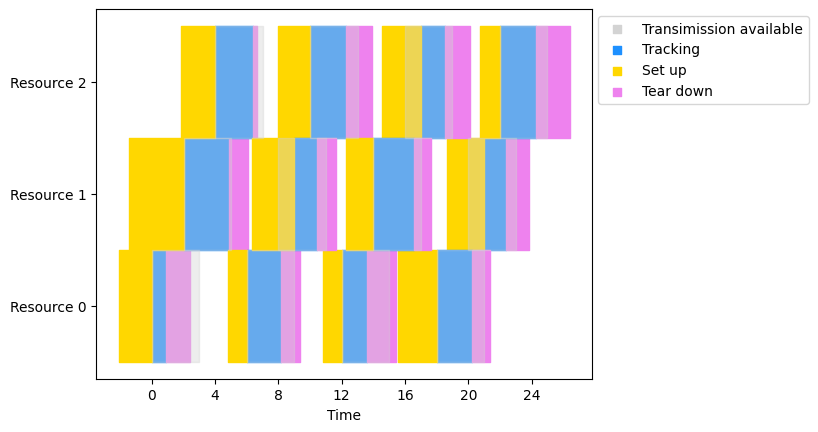

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# get feasible solutions
feasibles = results.feasible()
if feasibles.evaluation.objective == []:
    print('No feasibles solution')
else:
    # extract indices for x_{n, m, k, t} = 1 
    n_indices = feasibles.record.solution['x'][0][0][0]
    m_indices = feasibles.record.solution['x'][0][0][1]
    k_indices = feasibles.record.solution['x'][0][0][2]
    t_indices = feasibles.record.solution['x'][0][0][3]
    # make plot
    fig, ax = plt.subplots()
    # set x- and y-axis
    ax.set_xlabel("Time")
    ax.set_yticks(range(inst_M))
    ax.set_yticklabels(["Resource {}".format(m) for m in range(inst_M)])
    ax.get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
    # make bar plot for transmission using broken_barh
    for n, m, k, t in zip(n_indices, m_indices, k_indices, t_indices):
        ax.broken_barh([(t, inst_dr[n])], (m-0.5, 1), color="dodgerblue")
        ax.broken_barh([(t-inst_su[n], inst_su[n])], (m-0.5, 1), color="gold")
        ax.broken_barh([(t+inst_dr[n], inst_td[n])], (m-0.5, 1), color="violet")
    # make bar plot for available time
    for m, (list_tn, list_tf) in enumerate(zip(inst_tn, inst_tf)):
        for tn, tf in zip(list_tn, list_tf):
            ax.broken_barh([(tn, tf-tn-1)], (m-0.5, 1), color="lightgray", alpha=0.4)
    # make legend
    ax.scatter([], [], color="lightgray", label="Transimission available", marker="s")
    ax.scatter([], (), color="dodgerblue", label="Tracking", marker="s")
    ax.scatter([], (), color="gold", label="Set up", marker="s")
    ax.scatter([], (), color="violet", label="Tear down", marker="s")
    ax.legend(bbox_to_anchor=(1.45, 1.0))
    # show plot
    plt.show()        

<!-- 灰色部分は、それぞれのリソースが衛星と通信可能な時間帯を表します。
青色は衛星との通信を実行しているトラッキング時間です。
黄色とマゼンタ色はそれぞれ、通信前のセットアップ時間と、通信後のティアダウン時間を表現しています。
全てのトラッキング時間が、灰色の通信可能時間帯に重なっていることがわかります。 -->

The gray regions indicate the times when each resource can communicate with the satellite.
The blue bands represent the tracking.
The yellow and magenta colors represent the setup time and teardown time for each request, respectively.
We can see that all tracking durations overlap the gray communication available time.

<!-- ## 参考文献 -->

## References

* [Guillaume et al., 2022, "Deep Space Network Scheduling Using Quantum Annealing"](https://ieeexplore.ieee.org/document/9863923)  
* [Event Horizon Telescope](https://eventhorizontelescope.org/)  